<center><img src="https://perceivelab.github.io/knowledge-discovery-course/imgs/logo.jpg" width="300" height="103"></center>
<p align=center>Master's Degree in Data Science for Management</p>
<p align=center><b>Neural Computing Project</b> | A.A. 2020/21</p>
<p align=center>Ylenia Messina</p>


# Introduction

The work in this project is aimed at building a neural network infrastructure in the context of a *classification* problem.

In [ ]:
# Import libraries & modules
import io
import requests
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import confusion_matrix

import torch
from torch import nn
import torch.utils.data as dt

# Set seed for results reproducibility
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)

## Dataset: Sephora Sales

In [ ]:
# Import dataset from Github
url_data = "https://raw.githubusercontent.com/yleniamess/Sephora_Products_Rating_Class/main/sephora_sales.csv?token=ASJN3JHLA6XYNHHHXVA5KTLA4LQA4"
data = pd.read_csv(url_data)
data = data.drop(data.filter(regex='Unnamed', axis=1), axis=1)

print('Number of observations: ', data.shape[0],'; Number of features: ', data.shape[1])
data.head()

Number of observations:  9168 ; Number of features:  20


,id,brand,category,name,size,rating,number_of_reviews,love,price,value_price,MarketingFlags,MarketingFlags_content,options,details,how_to_use,ingredients,online_only,exclusive,limited_edition,limited_time_offer
0,2218774,Acqua Di Parma,Fragrance,Blu Mediterraneo MINIATURE Set,5 x 0.16oz/5mL,4,4.0,3002.0,66.0,75.0,True,online only,no options,This enchanting set comes in a specially handc...,Suggested Usage:-Fragrance is intensified by t...,Arancia di Capri Eau de Toilette: Alcohol Dena...,1,0,0,0
1,2044816,Acqua Di Parma,Cologne,Colonia,0.7 oz/ 20 mL,4.5,76.0,2700.0,66.0,66.0,True,online only,- 0.7 oz/ 20 mL Spray - 1.7 oz/ 50 mL Eau d...,An elegant timeless scent filled with a fresh-...,no instructions,unknown,1,0,0,0
2,1417567,Acqua Di Parma,Perfume,Arancia di Capri,5 oz/ 148 mL,4.5,26.0,2600.0,180.0,180.0,True,online only,- 1oz/30mL Eau de Toilette - 2.5 oz/ 74 mL E...,Fragrance Family: Fresh Scent Type: Fresh Citr...,no instructions,Alcohol Denat.- Water- Fragrance- Limonene- Li...,1,0,0,0
3,1417617,Acqua Di Parma,Perfume,Mirto di Panarea,2.5 oz/ 74 mL,4.5,23.0,2900.0,120.0,120.0,True,online only,- 1 oz/ 30 mL Eau de Toilette Spray - 2.5 oz/...,Panarea near Sicily is an an island suspended ...,no instructions,unknown,1,0,0,0
4,2218766,Acqua Di Parma,Fragrance,Colonia Miniature Set,5 x 0.16oz/5mL,3.5,2.0,943.0,72.0,80.0,True,online only,no options,The Colonia Miniature Set comes in an iconic A...,an indisputable pinnacle of Italian luxury.Th...,Suggested Usage:-Fragrance is intensified by t...,Colonia: Alcohol Denat.- Water- Fragrance- Lim...,1,0,0


The dataset used includes information about *Sephora sales*, the French multinational retailer of personal care and beauty products.

It consists of **9168 observations** (products) and **20 features** with mixed datatypes:

1.  **id** (*integer*): id of the product;
2.  **brand** (*object*): brand of the product at Sephora's website;
3.  **category** (*object*): category of the product at Sephora's website;
4.  **name** (*object*): name of the product at Sephora's website;
5.  **size** (*object*): size of the product;
6.  **rating** (*float*): customers can rate a product on a scale of 1 to 5 stars, so a product rating represents the average number of stars;
7.  **number_of_reviews** (*integer*): number of reviews of the product;
8.  **love** (*integer*): number of people loving the product, that is number of people who flagged the "heart" icon on the product sheet;
9.  **price** (*float*): price of the product;
10. **value_price** (*float*): value price of the product (for discounted products) that is the perceived or estimated value of the product for the customer;
11. **MarketingFlags** (*boolean*): marketing flags of the product from the website if they were exclusive or sold online only etc.;
12. **MarketingFlags_content** (*object*): kinds of marketing flags of the product;
13. **options** (*object*): options available on the website for the product such as colors and sizes;
14. **details** (*object*): details of the product available on the website;
15. **how_to_use** (*object*): instructions on how to use the product (if available);
16. **ingredients** (*object*): ingredients of the product (if available);
17. **online_only** (*integer*): whether the product is sold online only;
18. **exclusive** (*integer*): whether the product is sold exclusively on Sephora's website;
19. **limited_edition** (*integer*): whether the product is limited edition;
20. **limited_time_offer** (*integer*): whether the product has a limited time offer.


In [ ]:
# View the type of each feature
data.dtypes

id                          int64
brand                      object
category                   object
name                       object
size                       object
rating                     object
number_of_reviews         float64
love                      float64
price                     float64
value_price               float64
MarketingFlags             object
MarketingFlags_content     object
options                    object
details                    object
how_to_use                 object
ingredients                object
online_only                object
exclusive                  object
limited_edition            object
limited_time_offer         object
dtype: object

## Data cleaning

This first section is dedicated to the preliminary phase of data cleaning, which resulted in a resetting of the general shape of the dataset.

In particular:

*   The number of features was reduced to **10**, dropping those features considered not so useful for the purpose of the analysis, such as the *id* feature, as well as the ones with textual content (*brand*, *size*, *options*, *details* etc.), and also *MarketingFlags* and *MarketingFlags_content* since they were basically a repetition of the binary variables *online_only*, *exclusive*, *limited_edition* and *limited_time_offer*.
*   The number of observations was reduced as well, as a consequence of the removal of all the rows containing missing values and/or wrong records (whose presence was due to an incorrect configuration of the csv format file used to store the data). Furthermore, as it will be seen in the exploratory analysis section, a large portion of *outliers* was removed too.


In [ ]:
# Drop some not useful features
data = data.drop(['id',
                  'brand',
                  'size', 
                  'MarketingFlags', 
                  'MarketingFlags_content', 
                  'options',
                  'details', 
                  'how_to_use', 
                  'ingredients'], axis=1)

# Check if there are any duplicates
data.duplicated().any()

False

In [ ]:
# Set 'name' column as dataframe index
data = data.set_index('name')
print('Number of observations: ', data.shape[0],'; Number of features: ', data.shape[1])
data.head()

Number of observations:  9168 ; Number of features:  10


,category,rating,number_of_reviews,love,price,value_price,online_only,exclusive,limited_edition,limited_time_offer
name,,,,,,,,,,
Blu Mediterraneo MINIATURE Set,Fragrance,4,4.0,3002.0,66.0,75.0,1,0,0,0
Colonia,Cologne,4.5,76.0,2700.0,66.0,66.0,1,0,0,0
Arancia di Capri,Perfume,4.5,26.0,2600.0,180.0,180.0,1,0,0,0
Mirto di Panarea,Perfume,4.5,23.0,2900.0,120.0,120.0,1,0,0,0
Colonia Miniature Set,Fragrance,3.5,2.0,943.0,72.0,80.0,Colonia: Alcohol Denat.- Water- Fragrance- Lim...,1,0,0


In [ ]:
# Check for missing values
data.isnull().sum()

category               0
rating                 5
number_of_reviews      5
love                   5
price                  3
value_price            3
online_only           43
exclusive             29
limited_edition       27
limited_time_offer    21
dtype: int64

In [ ]:
# Remove observations with missing values (nan values)
initial_n_obs = data.shape[0]
data = data.dropna(0)
print("Removed", (initial_n_obs - data.shape[0]), "observations that contained missing values.")

Removed 52 observations that contained missing values.


Despite having apparently removed all the missing values ​​reported as "nan", a more accurate exploration of the features taken one by one brought to light the presence of further missing values, however, labeled by strings such as "*unknown*", "*no category*". Even "0" is to be considered as missing value as regards the **rating** feature for which the minimum value is 1, inasmuch 0 would indicate that no rating has been left to the product by the customer who purchased it. Consequently, such observations were removed.

Furthermore, in some features there are wrong values ​​pertaining to other features. This circumstance is due to the fact that the initial features with textual content such as *ingredients*, *details* etc. contain commas, and since the dataset is a comma-delimited csv file, it resulted in an incorrect import of the latter. Therefore, further observations were obviously removed.

In [ ]:
# Check value counts to display the wrong records
cols = ['rating', 'online_only', 'exclusive', 'limited_edition', 'limited_time_offer']
for col in cols:
  print(f' {col} value counts:')
  print(data[col].value_counts())
  print("------------------------------------------")

 rating value counts:
4.5                                           3513
4                                             2834
3.5                                           1042
5                                              867
0                                              392
3                                              306
2.5                                             88
2                                               39
1                                               23
1.5                                              9
 gel: 0.0253 oz/ 0.75 mL                         1
 0.08 oz/2.5 g Catch The Light Highlighter       1
 0.33 oz/ 10 mL each                             1
Name: rating, dtype: int64
------------------------------------------
 online_only value counts:
0                                                                                                                                                                                                                         

In [ ]:
## Remove missing values and wrong records
initial_n_obs = data.shape[0]

# category
data = data[data.category != "no category"]

# rating
data = data.drop(data[(data.rating == "0")].index)
data = data.drop(data[data.rating == " gel: 0.0253 oz/ 0.75 mL"].index)
data = data.drop(data[data.rating == " 0.33 oz/ 10 mL each"].index) 
data = data.drop(data[data.rating == " 0.08 oz/2.5 g Catch The Light Highlighter"].index)
data = data.drop(data[data.rating == " 0.08 oz/2.5 g Catch The Light Highlighter"].index)
data['rating'] = data['rating'].astype('float64')

# online_only
data = data[(data.online_only == "0") | (data.online_only == "1")]
data['online_only'] = data['online_only'].astype('uint8')

# exclusive
data = data[(data.exclusive == "0") | (data.exclusive == "1")]
data['exclusive'] = data['exclusive'].astype('uint8')

# limited_edition
data = data[(data.limited_edition == "0") | (data.limited_edition == "1")]
data['limited_edition'] = data['limited_edition'].astype('uint8')

# limited_time_offer
data = data[(data.limited_time_offer == "0") | (data.limited_time_offer == "1")]
data['limited_time_offer'] = data['limited_time_offer'].astype('uint8')

print("Removed", (initial_n_obs - data.shape[0]), "observations that contained missing values or wrong records.")

Removed 711 observations that contained missing values or wrong records.


The **category** feature - as the name itself suggests - lent itself well to be used as a *categorical* variable. So, all its values ​​were grouped among 6 categories, each one identifying a different type of beauty/personal care product (*skincare*, *makeup*, *bath_body*, *hair*, *fragrance*, *other*).

In [ ]:
# Transform 'category' feature into a categorical one
skincare = ["Anti-Aging","Blemish & Acne Treatments","Decollete & Neck Creams", "Exfoliators",
            "Eye Masks","Face Masks","Face Oils","Face Serums","Face Sets","Face Wash",
            "Face Wash & Cleansers","Face Wipes","Facial Cleansing Brushes","Facial Peels",
            "Facial Rollers","For Face","Face Brushes","Moisturizer & Treatments","Moisturizers",
            "Night Creams","Sheet Masks","Skincare","Skincare Sets","Toners"]

makeup = ["BB & CC Cream","BB & CC Creams","Blotting Papers","Blush","Bronzer","Brush Sets",
          "Cheek Palettes","Eye Palettes","Color Correct","Concealer","Contour","Eye Brushes",
          "Eye Sets","Eyelash Curlers","Eye Cream","Eye Creams & Treatments","Eye Primer","Eyebrow",
          "Eyeliner","Eyeshadow","Face Primer","False Eyelashes","Foundation","Highlighter","Lid Shadow Brush",
          "Lip Balm & Treatment","Lip Balms & Treatments","Lip Brushes","Lip Gloss","Lip Liner","Lip Plumper",
          "Lip Sets","Lip Stain","Lip Sunscreen","Lip Treatments","Lipstick","Liquid Lipstick","Makeup",
          "Makeup & Travel Cases","Makeup Bags & Travel Cases","Makeup Palettes","Makeup Removers","Mascara",
          "Powder Brush","Setting Spray & Powder","Tinted Moisturizer"]

bath_body = ["Bath & Body","Bath & Shower","Bath Soaks & Bubble Bath","Body Lotions & Body Oils",
             "Body Moisturizers","Body Products","Body Sprays & Deodorant","Body Wash & Shower Gel",
             "Cellulite & Stretch Marks","Deodorant & Antiperspirant","Deodorant for Men","Hand Cream & Foot Cream",
             "Scrub & Exfoliants","Lotions & Oils","For Body"]

hair = ["Color Care","Conditioner","Curling Irons","Curls & Coils","Hair" ,"Hair Accessories","Hair Brushes & Combs",
        "Hair Dryers","Hair Masks","Hair Oil","Hair Primers","Hair Products","Hair Spray","Hair Straighteners & Flat Irons",
        "Hair Styling & Treatments","Hair Styling Products","Hair Thinning & Hair Loss","Scalp & Hair Treatments","Shampoo",
        "Dry Shampoo","Leave-In Conditioner","Shampoo & Conditioner"]

fragrance = ["Body Mist & Hair Mist","Mists & Essences","Cologne",
             "Cologne Gift Sets","Fragrance","Perfume",
             "Perfume Gift Sets","Rollerballs & Travel Size"]

other = ["Accessories","After Sun Care","Aftershave","Beauty Supplements",
         "Body Sunscreen","Brush Cleaners","Candles","Candles & Home Scents","Cleansing Brushes",
         "Diffusers","Face Sunscreen","Hair Removal","Hair Removal & Shaving","High Tech Tools",
         "Holistic Wellness","Mini Size","Mirrors & Sharpeners","Nail","Self Tanners","Shaving",
         "Spa Tools","Sponges & Applicators","Sunscreen","Teeth Whitening","Tweezers & Eyebrow Tools",
         "Value & Gift Sets","Wellness"]

for x in data['category']:
    if x in skincare:
        data.category[data.category == x] = "skincare"
    elif x in makeup:
        data.category[data.category == x] = "makeup"
    elif x in bath_body:
        data.category[data.category == x] = "bath_body"
    elif x in hair:
        data.category[data.category == x] = "hair"
    elif x in fragrance:
        data.category[data.category == x] = "fragrance"
    elif x in other:
        data.category[data.category == x] = "other"

data['category'] = data['category'].astype('category')
data['category'].cat.categories

Index(['bath_body', 'fragrance', 'hair', 'makeup', 'other', 'skincare'], dtype='object')

Even the **rating** feature, as it will be better explained in the exploratory analysis section, was converted into a categorical one with **5** categories.

In [ ]:
# Convert 'rating' into categorical
for x in data['rating']:
    if 1 <= x < 2:
      data.rating[data.rating == x] = "1 Star"
    elif 2 <= x < 3:
      data.rating[data.rating == x] = "2 Stars"
    elif 3 <= x < 4:
      data.rating[data.rating == x] = "3 Stars"
    elif 4 <= x < 5:
      data.rating[data.rating == x] = "4 Stars"
    elif x == 5:
      data.rating[data.rating == x] = "5 Stars"
data['rating'] = data['rating'].astype('category')
data['rating'].cat.categories

Index(['1 Star', '2 Stars', '3 Stars', '4 Stars', '5 Stars'], dtype='object')

# Exploratory Analysis

Firstly, let's focus on the **rating** feature, which is going to be considered as the response variable to predict in the classification problem.
Customers can rate a product on a scale of 1 to 5 stars, so the overall product rating is computed as the sum of all the ratings made for that product divided by the number of people who rated. Obviously it is a continuous variable, as it can take any value in the range from 1 to 5 (0 if no one rated that product). However, the available dataset collected only products with a rating of 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5 or 5. Consequently, it seems to make more sense to treat this feature as a multi-class categorical variable rather than a continuous one: this is why it was transformed as such in data-cleaning process.

The countplot shows how the dataset is very *unbalanced*, containing a lot of observations (products) rated mostly with *4 Stars*, and very few with a rating of *1 Star* or *2 Stars*.

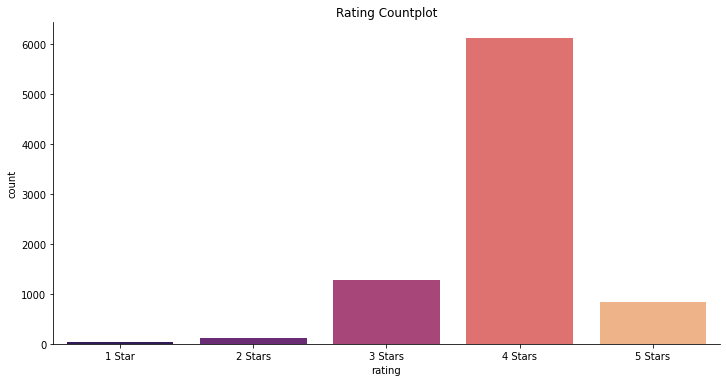

In [ ]:
# Countplot
sns.catplot(x="rating", kind="count", palette="magma", data=data, aspect=2).set(title="Rating Countplot");

## Numerical variables

Here, the *numerical* features **number_of_reviews**, **love**, **price** and **value_price** are analyzed, by visualizing their distribution as well as their boxplot with respect to the **rating** feature.

At first sight, we can only say how noisy the data are: the plots obtained are not so easy to interpret due to the presence of a significant number of outliers for all four variables.

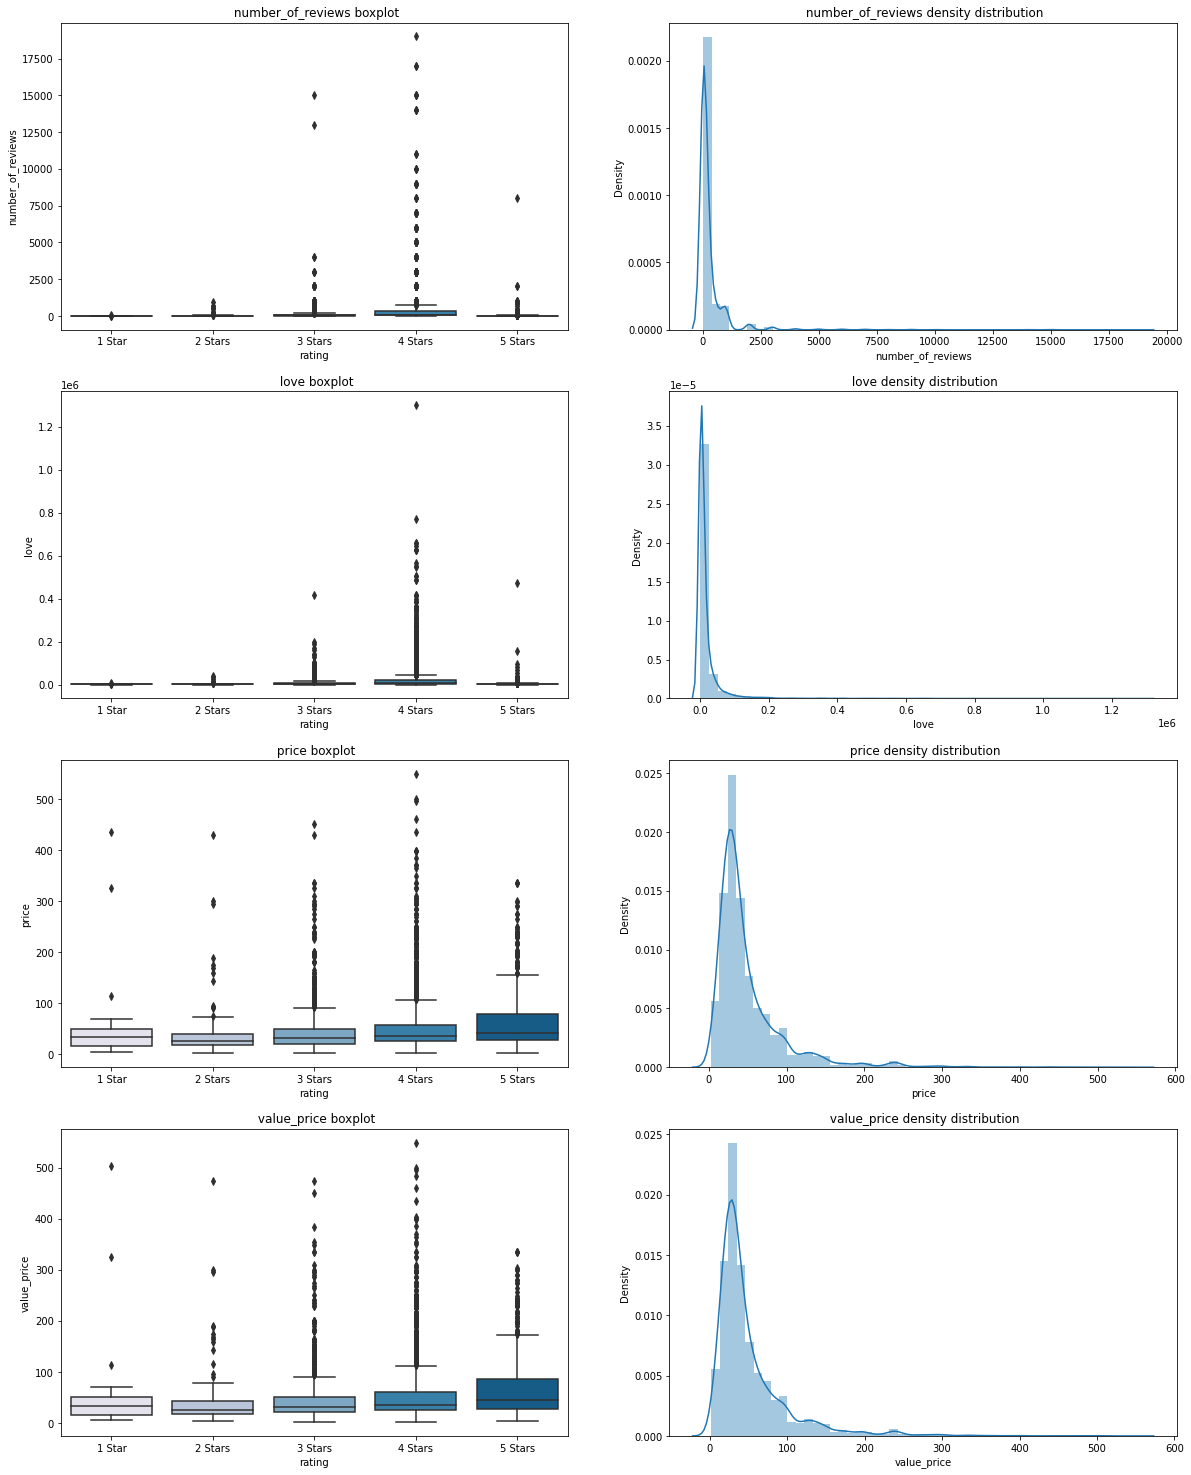

In [ ]:
# Boxplot & density distribution
num_cols = data[['number_of_reviews','love','price','value_price']]
numerical = list(num_cols.columns.values)

fig, ax = plt.subplots(4, 2, figsize=(20,26))
ax = ax.ravel()
c=0
for i, var in enumerate(data[numerical]):
    sns.boxplot(x='rating', y=var, data=data, palette="PuBu", ax=ax[i+c]).set(title=f' {var} boxplot')
    sns.distplot(data[var], ax=ax[i+c+1]).set(title=f' {var} density distribution')               
    c = c+1
fig.show()

Therefore, observations representing outliers were removed, in order to avoid as much as possible not to invalidate the analysis with any anomalies.

In [ ]:
# Remove outliers
initial_n_obs = data.shape[0]

integer = ['price','value_price']
for var in integer:
  Q1 = data[var].quantile(0.25)
  Q3 = data[var].quantile(0.75)
  IQR = Q3 - Q1
  outliers = data[(data[var] < (Q1 - 1.5 * IQR))|(data[var] > (Q3 + 1.5 * IQR))].index
  data = data.drop(outliers)

floats = ['number_of_reviews', 'love']
for var in floats:
  data = data[data[var].between(data[var].quantile(.15), data[var].quantile(.90))]

print("Removed", (initial_n_obs - data.shape[0]), "outliers.")
print('Number of observations: ', data.shape[0],'; Number of features: ', data.shape[1])

Removed 4232 outliers.
Number of observations:  4173 ; Number of features:  10


However, not all outliers were removed: in particular the number of outliers for *number_of_reviews* is still large. But otherwise there was the risk of excessively reducing the dataset and lose those few observations with a rating of "1 Star". In fact, after the data cleaning process and the removal of the outliers, the dataset now counts 4173 observations out of the initial 9168.

At least, we can now observe more clearly how *number_of_reviews* and *love* don't follow a gaussian distribution, being positively skewed instead. In fact, in the density distribution plots there are long right-tails. Also, in the boxplots the medians are closer to the bottom of the box, and the whiskers are shorter on the lower end of the box. Both plot characteristics indicate the asymmetrical natural of the features distribution (positive-skewness).

On the other hand, *price* and *value_price* boxplots suggest a more symmetric distribution. The density distribution plots are closer to a gaussian distribution, with some skewness on the right - presumably due to the presence of outliers. However the presence of these observations with values ​​further away from the median makes sense considering that the products with higher prices (and value prices) are a minority.

As regards *number_of_reviews* and *love*, it is assumed that the longer a product has been on the market, the more reviews it will have received and the more consent (*love*) it will have garnered from customers. In this sense, outliers are presumably those observations representing the "older" products.

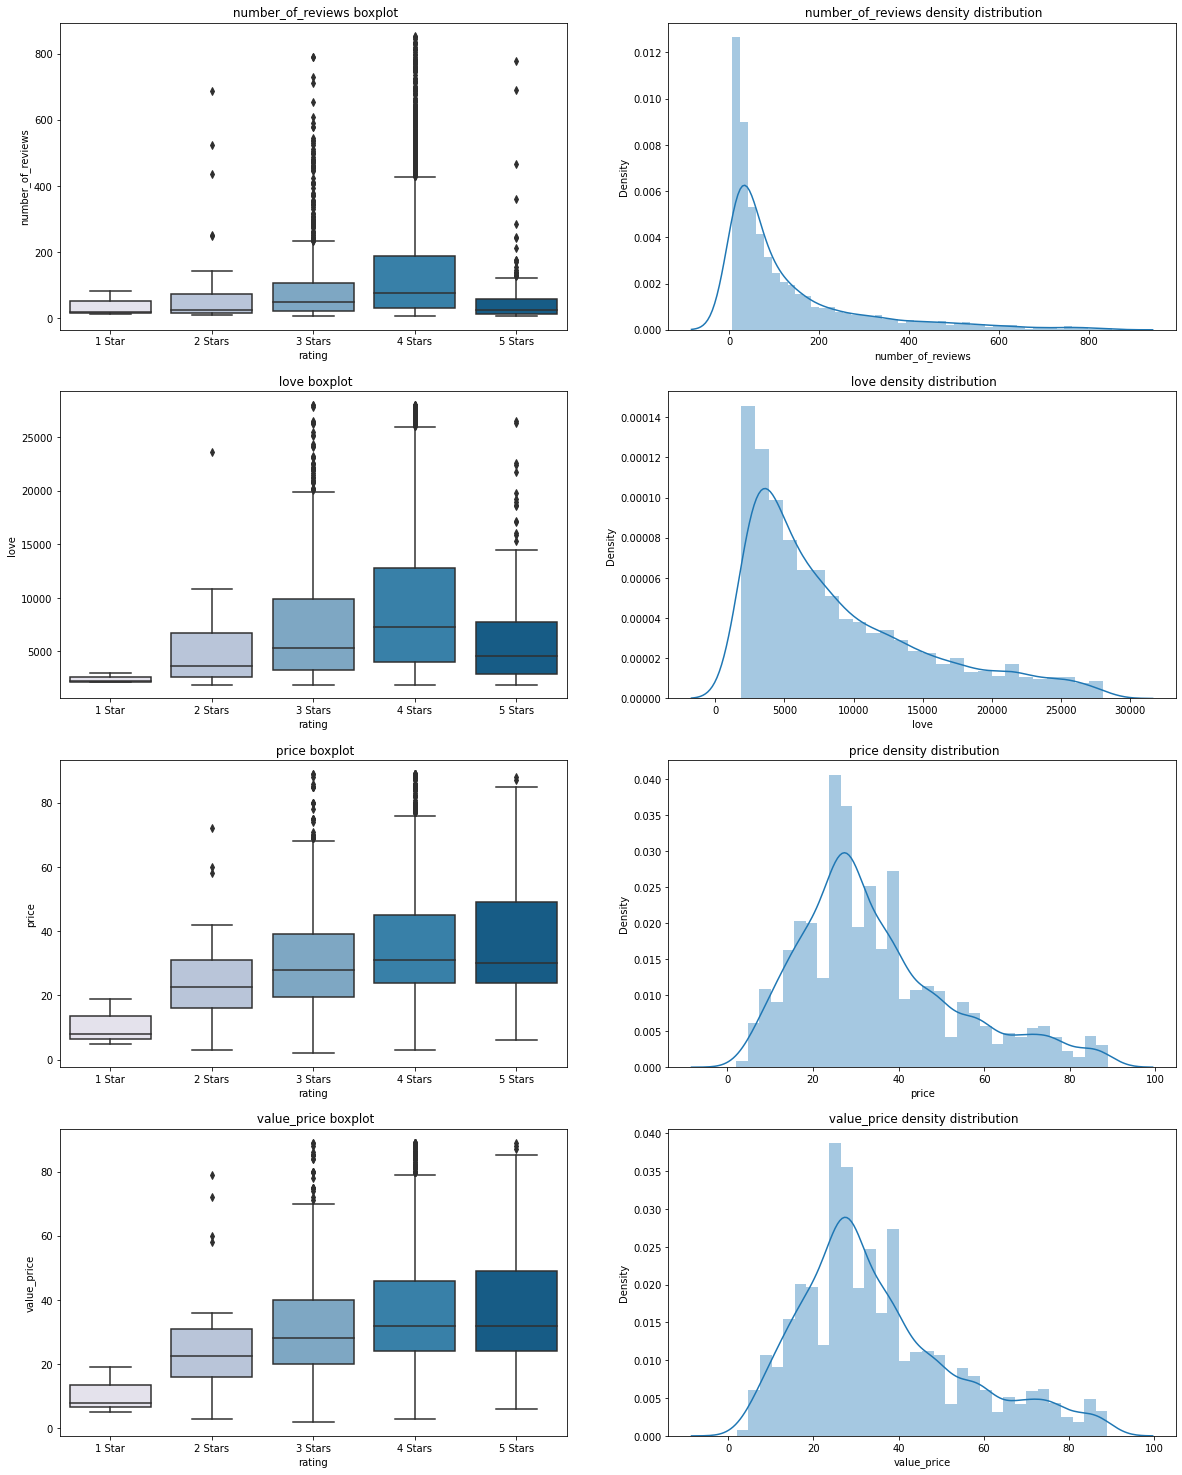

In [ ]:
# Boxplot & density distribution after outliers removal
num_cols = data[['number_of_reviews','love','price','value_price']]
numerical = list(num_cols.columns.values)

fig, ax = plt.subplots(4, 2, figsize=(20,26))
ax = ax.ravel()
c=0
for i, var in enumerate(data[numerical]):
    sns.boxplot(x='rating', y=var, data=data, palette="PuBu", ax=ax[i+c]).set(title=f' {var} boxplot')
    sns.distplot(data[var], ax=ax[i+c+1]).set(title=f' {var} density distribution')               
    c = c+1
fig.show()

In [ ]:
round(num_cols.describe(), 2)

,number_of_reviews,love,price,value_price
count,4173.00,4173.00,4173.00,4173.00
mean,132.03,8804.22,35.03,35.61
std,159.77,6377.70,18.39,18.77
min,7.00,1900.00,2.00,2.00
25%,26.00,3800.00,22.50,23.00
50%,65.00,6700.00,30.00,30.00
75%,169.00,12200.00,45.00,45.00
max,852.00,28000.00,89.00,89.00


## Categorical variables

The **category** feature is analyzed by visualizing its countplot, put in relationship with the **rating** feature.

We can observe that most of the products in the dataset belong to the "makeup" and "skincare" categories. The minority category is "bath_body".
However, for each category, the countplot "shape" is almost the same, suggesting there is likely no difference between the groups of products in terms of rating behavior: as it was quite predictable, most of the products within each category are rated as "4 Stars".

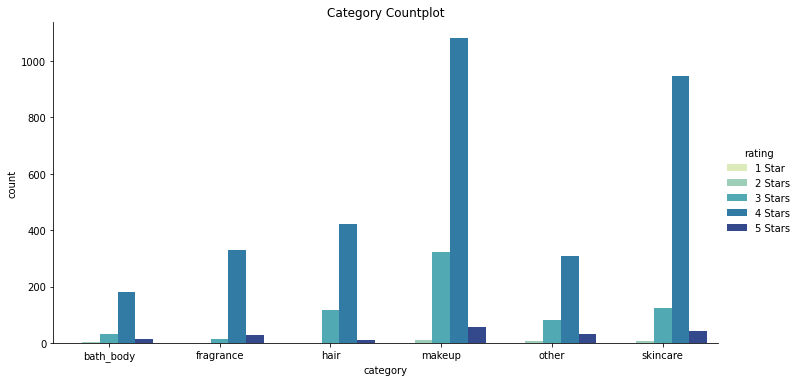

In [ ]:
# Countplot
sns.catplot(x="category", hue='rating', kind="count", palette="YlGnBu", data=data, aspect=2).set(title="Category Countplot");

## Binary variables

The *binary* features **online_only**, **exclusive**, **limited_edition** and **limited_time_offer** are analyzed by visualizing their countplot, put in relationship with the **rating** feature. 

We can observe that only a minority of products is exclusive, sold online only, limited edition and/or offered in a limited time, which makes sense.

For each binary feature the proportional distribution of the counts among the rating classes is almost the same, suggesting that whether the product has some marketing flags (*online_only*, *exclusive*, *limited_edition*, *limited_time_offer*) or not, it doesn't really affect in terms of rating behavior: most of the products are always rated with "4 Stars".

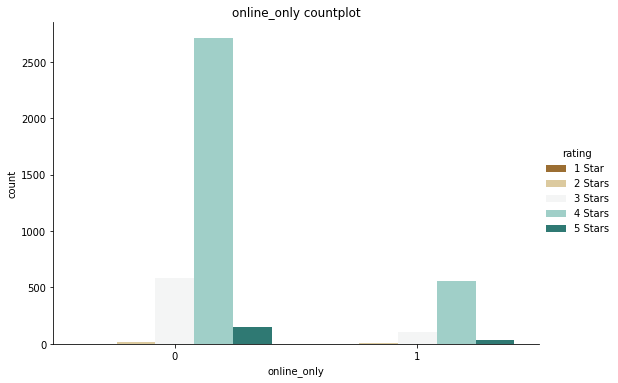

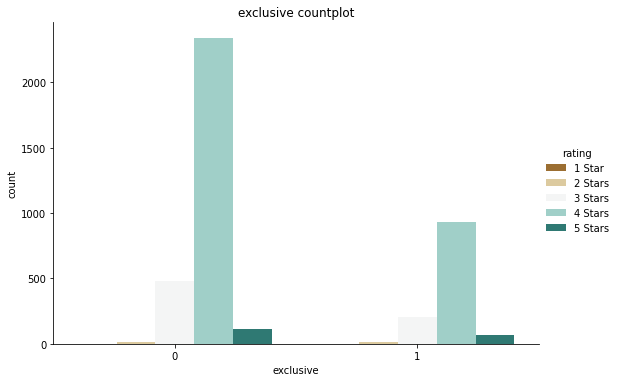

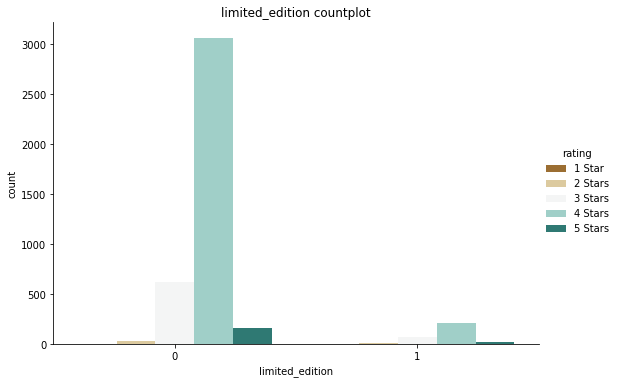

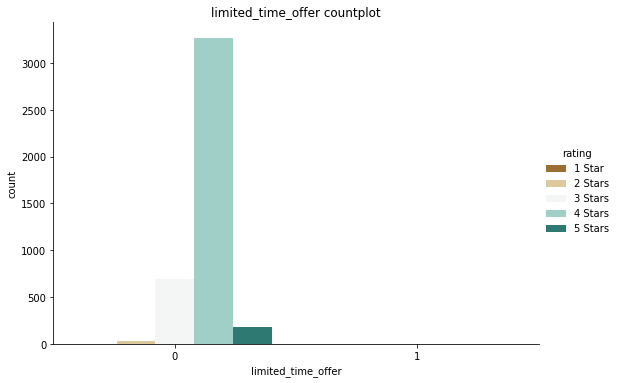

In [ ]:
# Countplot
binary = data[['online_only','exclusive','limited_edition','limited_time_offer']]
binary = list(binary.columns.values)

for i, var in enumerate(data[binary]):
  sns.catplot(x=var, hue='rating', kind="count", palette="BrBG", data=data, aspect=1.5).set(title=f'{var} countplot');

# Problem designing

The problem outlined in this project is a **classification** problem: predict the **rating** - from 1 to 5 stars - of any product in the Sephora online catalog, starting from some of the quantitative and non-quantitative information that can be found on the Sephora webpage.

In this sense, the “rating” feature represents the *response* variable, while the *predictors* are the number of reviews for a product, the number of people loving the product, the price, the value-price as perceived by the customers, the category, and the information whether the product is sold online only, is exclusive, limited edition and/or offered for a limited time.

Before the neural network can be defined and built, data requires some pre-processing.

## Data pre-processing

Firstly, both "rating" and “category” features need to be encoded due to their categorical datatype. Two different approaches are used to encode the variables.

*Rating* is **label encoded**, that is each label is simply converted to a number (starting from 0). 

On the other hand, for *category* using an ordinal scale will not make sense as it conveys purely qualitative information. “**One-hot encoding**” is the most appropriate option. It consists in replacing the categorical feature with the creation of new so-called “dummy” variables – which are binary variables – one for each possible label of the original variable. For each observation, one-hot encoding assigns 1 to the dummy variable that represents the original label and 0 to all the others.

In [ ]:
# Label encoding 'rating'
def ordered_labels(df, col, order):
    df[col] = df[col].cat.reorder_categories(order, ordered=True)  # reorder levels of the category
    df[col] = df[col].cat.codes.astype(int)                        # code the ordered levels and cast the column to "int" dtype

rating_order = ['1 Star', '2 Stars', '3 Stars', '4 Stars', '5 Stars']
ordered_labels(data, 'rating', rating_order)

In [ ]:
# One-hot encoding 'category'
data = pd.concat([data, pd.get_dummies(data['category'])],axis=1).drop('category',axis=1)

From the analysis of the correlation matrix, we can observe that all predictors have approximately the same level of correlation - which is not particularly high, neither in positive nor in negative - with the *target* variable **rating**. We can instead notice, some stronger correlations between the predictor variables that were quite predictable, in particular:

*   *number_of_reviews* and *love* are highly and positively correlated;
*   *price* and *value_price* are even more positively correlated;
*   dummy variables corresponding to the labels of the original 'category' variable, are negatively correlated between each other, especially *skincare* and *makeup*.

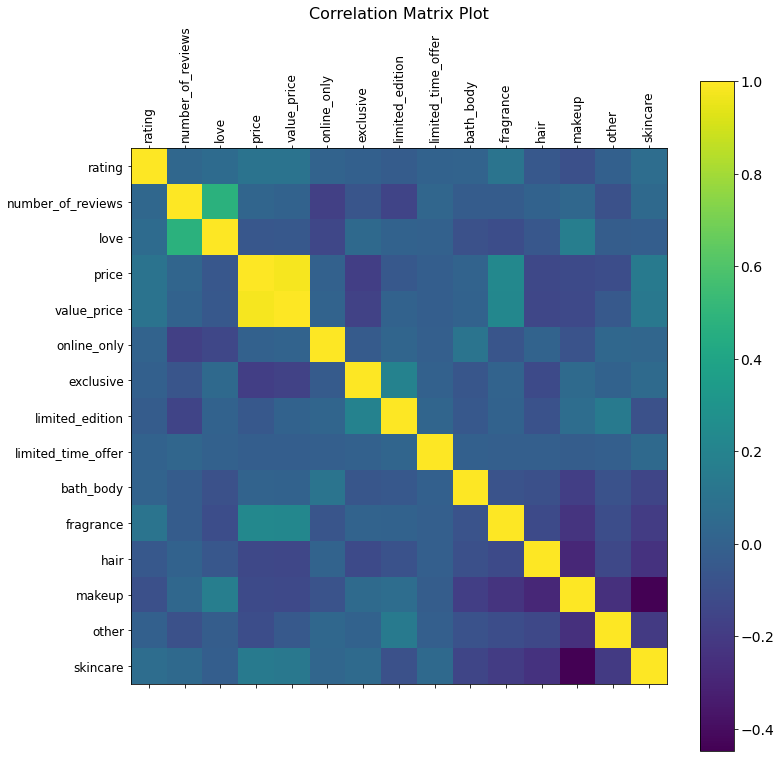

In [ ]:
# Correlation Matrix
expl_data = data.iloc[:]
cols = expl_data.columns.tolist()
expl_data = RobustScaler().fit_transform(expl_data)
expl_data = pd.DataFrame(expl_data, columns = cols)

f = plt.figure(figsize=(12,12))
plt.matshow(expl_data.corr(), fignum=f.number)
plt.xticks(range(expl_data.select_dtypes(['number']).shape[1]), expl_data.select_dtypes(['number']).columns, fontsize=12, rotation=90)
plt.yticks(range(expl_data.select_dtypes(['number']).shape[1]), expl_data.select_dtypes(['number']).columns, fontsize=12)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix Plot',  y=1, fontsize=16);

The dataset is then split in training and test set such that training test contains the 65% of the original observations while test set contains the remaining 35%. 

Also, both training and test set are scaled, exploiting the "*robust scaler*" provided by scikit-learn library.
This Scaler removes the median and scales the data according to the default IQR (Interquartile Range), which is the range between the 1st quartile (25th quantile) and the 3rd quartile (75th quantile). For that, such scaler is more robust to outliers than usual standardization done by removing the mean and scaling to unit variance (since outliers can often influence the sample mean / variance in a negative way).

In [ ]:
# Split into training and test set
target = data['rating']
data = data.drop('rating', axis=1)
train_features, test_features, train_labels, test_labels = train_test_split(data, target, 
                                                                            test_size  = 0.35, 
                                                                            random_state = random_seed)

# Scale
train_features = RobustScaler().fit_transform(train_features)
test_features = RobustScaler().fit_transform(test_features)

# Save dataframe with products names in test set (for later)
products = test_labels.index.to_frame()
products.index = range(len(products.index))

As emerged in the exploratory analysis, the dataset used is *unbalanced*. Therefore, also training and test sets obtained from the split are inevitably unbalanced in the same way.

In [ ]:
train_labels.value_counts(normalize=True)*100

3    77.802360
2    16.887906
4     4.719764
1     0.516224
0     0.073746
Name: rating, dtype: float64

In [ ]:
test_labels.value_counts(normalize=True)*100

3    79.534565
2    15.742642
4     3.696099
1     0.958248
0     0.068446
Name: rating, dtype: float64

At this point, data only need to be converted into *tensors* to serve as inputs for the neural network.

In [ ]:
# Convert data into tensor
train_features = torch.tensor(train_features, dtype=torch.float)
test_features = torch.tensor(test_features, dtype=torch.float)
train_labels = torch.tensor(train_labels, dtype=torch.long)
test_labels = torch.tensor(test_labels, dtype=torch.long)

# Architecture setting

The most appropriate solution in terms of deep learning model is a basic feed-forward neural network. A feed-forward neural network is an artificial neural network where the information moves in only one direction from the input nodes, through the hidden nodes (if any) and to the output nodes.

In this case, the information will move from the initial **14** **input nodes** (the *predictor features*), and then eventually converge to a layer with **5 output nodes** (*rating classes*). Before **output layer**, information pass through a *ReLU* (*rectified linear activation function*) layer. The *ReLU* activation function basically will output the input directly if it is positive, otherwise it will output zero.

In order to define the number of *hidden layers* as well as the number of nodes that each of them should have, multiple alternatives with different configurations of the neural network were tested, using the resampling method of **k-fold cross validation**. Then, the architecture setting of the neural network that performed best was chosen.

The loss measure used is the **Cross-Entropy Loss**, also called "logarithmic loss" which measures the cross-entropy between the predicted and the actual value. This criterion combines the *Softmax activation function* principle and the *negative log likelihood loss*, but unlike negative log loss, cross-entropy also penalizes wrong but confident predictions and correct but less confident predictions, while negative log loss does not penalize according to the confidence of predictions. Also, Since the training set is unbalanced, the *nn.CrossEntropyLoss()* function was provided of the optional argument "weight", taking a 1D Tensor assigning weight to each of the 5 classes. 

All nodes of each layer are initialized with values from a normal distribution using the "*Xavier initialization*" method in order to avoid stability issues while training (such as vanishing or exploding gradients). Each bias is instead initialized with the scalar value 0.

In [ ]:
# Construct a PyTorch data iterator
def load_array(data_arrays, batch_size, is_train=True):
    dataset = dt.TensorDataset(*data_arrays)
    return dt.DataLoader(dataset, batch_size, shuffle=is_train)

# Loss measure
weights = torch.tensor([0.07, 0.51, 16.89, 77.80, 4.72])
loss = nn.CrossEntropyLoss(weight=weights)

# Define net with 1 or 2 hidden layers 
in_features = train_features.shape[1]
out_labels = 5       
def get_net(num_nodes1, num_nodes2):
    if num_nodes2 is not None:
      net = nn.Sequential(nn.Linear(in_features,num_nodes1),
                          nn.Linear(num_nodes1,num_nodes2),
                          nn.ReLU(),
                          nn.Linear(num_nodes2,out_labels))
    else:
      net = nn.Sequential(nn.Linear(in_features,num_nodes1),
                          nn.ReLU(),
                          nn.Linear(num_nodes1,out_labels))
    return net

# Initialize model parameters
def init_weights(m):             
    if type(m) == nn.Linear:
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)

In [ ]:
# Train function
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls, acc_train_ls, acc_test_ls = [], [], [], []
    train_iter = load_array((train_features, train_labels), batch_size)
    
    # Adam optimizer
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)

    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(loss(net(train_features), train_labels))
        # train accuracy
        out = net(train_features).detach()
        _, predicted = torch.max(out.data, 1)
        total_train = train_labels.size(0)
        correct_train = (predicted == train_labels).sum().item()
        acc_train = correct_train / total_train
        acc_train_ls.append(acc_train)
        if test_labels is not None:
          test_ls.append(loss(net(test_features), test_labels))
          # test accuracy
          out = net(test_features).detach()
          _, predicted = torch.max(out.data, 1)
          total_test = test_labels.size(0)
          correct_test = (predicted == test_labels).sum().item()
          acc_test = correct_test / total_test
          acc_test_ls.append(acc_test)
    return train_ls, test_ls, acc_train_ls, acc_test_ls

In [ ]:
# K-fold Cross validation
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

def k_fold(k, X_train, y_train, num_nodes1, num_nodes2, num_epochs, learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    net = get_net(num_nodes1, num_nodes2)
    net.apply(init_weights)
    for i in range(k):
      data = get_k_fold_data(k, i, X_train, y_train)
      train_ls, valid_ls, _, _ = train(net, *data, num_epochs, learning_rate,
                                 weight_decay, batch_size)

      train_l_sum += train_ls[-1]
      valid_l_sum += valid_ls[-1]
    
    return train_l_sum / k, valid_l_sum / k

In particular, 54 neural network models with different configurations in terms of number of hidden layers (from 1 to 2) and number of nodes in each of them, were tried out exploiting 5-fold cross validation.

Here, an untuned set of hyperparameters - learning rate, weight decay etc. - is picked, but they will be optimized in next section.

So for now, the network's weights are updated using **adam optimizer** on batches with a **batch size** of **128**: meaning weights are updated after every 128 samples have been evaluated. The entire training set is trained for **50** **epochs**. The network learns with a **learning rate** of 0.1, while the **weight decay** is instead set as 0.

In [ ]:
# Define neural network architecture via k-fold cross-validation
net_components = {'num_nodes1': list(range(4, 22, 2)),
                  'num_nodes2': list(range(4, 22, 4))}

nets = pd.DataFrame(columns=["num_nodes layer 1", "num_nodes layer 2",
                             "avg train loss", "avg valid loss"])

num_epochs = 50
learning_rate = 0.1
weight_decay = 0
batch_size = 128

k = 5
i = 0
# Nets with 1 hidden layer
for num_nodes1 in net_components['num_nodes1']:
  i = i + 1
  num_nodes2 = None
  train_l, valid_l = k_fold(k, train_features, train_labels, num_nodes1, num_nodes2, num_epochs, 
                            learning_rate, weight_decay, batch_size)
  print(f'({i}) 1 hidden layer - nodes: {num_nodes1}')
  print(f'{k}-fold validation | avg train loss: {float(train_l):f}, '
        f'avg valid loss: {float(valid_l):f}')
  nets = nets.append({'num_nodes layer 1': num_nodes1, #'num_nodes layer 2': None, 
                      'avg train loss': train_l.item(), 'avg valid loss': valid_l.item()}, ignore_index=True)
    
# Nets with 2 hidden layers
for num_nodes1 in net_components['num_nodes1']:
  for num_nodes2 in net_components['num_nodes2']:
    i = i + 1
    train_l, valid_l = k_fold(k, train_features, train_labels, num_nodes1, num_nodes2, num_epochs, 
                              learning_rate, weight_decay, batch_size)
    print(f'({i}) 2 hidden layers - layer 1 nodes: {num_nodes2},'
          f' layer 2 nodes: {num_nodes2}') 
    print(f'{k}-fold validation | avg train loss: {float(train_l):f}, '
          f'avg valid loss: {float(valid_l):f}')
    nets = nets.append({'num_nodes layer 1': num_nodes1, 'num_nodes layer 2': num_nodes2, 
                        'avg train loss': train_l.item(), 'avg valid loss': valid_l.item()}, ignore_index=True)
    
bestnet = nets.loc[[(nets["avg valid loss"]).idxmin()]]
layer2 = bestnet['num_nodes layer 2'].notnull().values[0]
if layer2 != False:
  num_nodes1, num_nodes2 = int(bestnet['num_nodes layer 1'].values[0]), int(bestnet['num_nodes layer 2'].values[0])
else:
  num_nodes1, num_nodes2 = int(bestnet['num_nodes layer 1'].values[0]), None

(1) 1 hidden layer - nodes: 4
5-fold validation | avg train loss: 0.197169, avg valid loss: 0.202632
(2) 1 hidden layer - nodes: 6
5-fold validation | avg train loss: 0.195746, avg valid loss: 0.203608
(3) 1 hidden layer - nodes: 8
5-fold validation | avg train loss: 0.193651, avg valid loss: 0.212758
(4) 1 hidden layer - nodes: 10
5-fold validation | avg train loss: 0.195669, avg valid loss: 0.204873
(5) 1 hidden layer - nodes: 12
5-fold validation | avg train loss: 0.193164, avg valid loss: 0.208906
(6) 1 hidden layer - nodes: 14
5-fold validation | avg train loss: 0.191238, avg valid loss: 0.206913
(7) 1 hidden layer - nodes: 16
5-fold validation | avg train loss: 0.195453, avg valid loss: 0.203084
(8) 1 hidden layer - nodes: 18
5-fold validation | avg train loss: 0.191862, avg valid loss: 0.207186
(9) 1 hidden layer - nodes: 20
5-fold validation | avg train loss: 0.189435, avg valid loss: 0.211882
(10) 2 hidden layers - layer 1 nodes: 4, layer 2 nodes: 4
5-fold validation | avg tra

The neural network that performs better, in terms of **avg cross-entropy loss** on validation set, is the one with:

In [ ]:
bestnet.head()

,num_nodes layer 1,num_nodes layer 2,avg train loss,avg valid loss
9,4.0,4.0,0.198189,0.200809


Here it is a graphical visualization of the neural network setting, exploiting *graphviz* library.

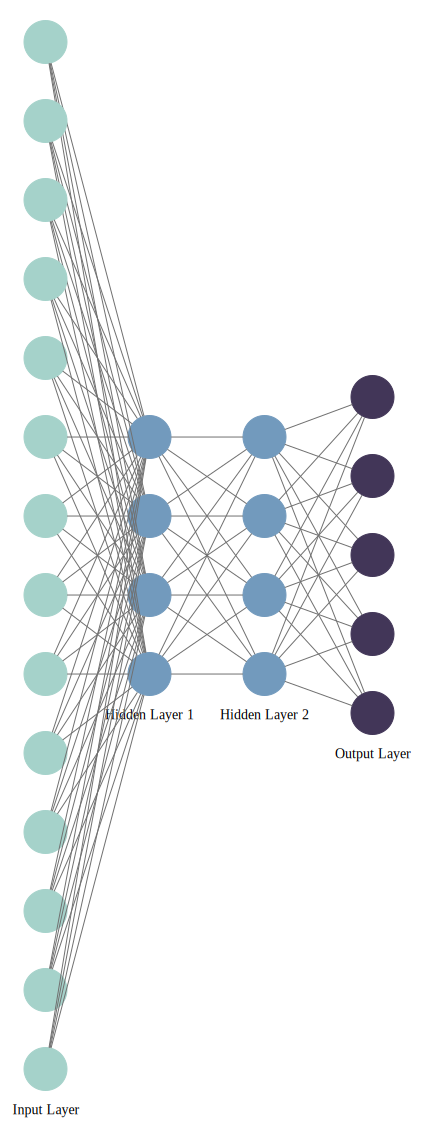

In [ ]:
# Neural Network Visualization
def ann_viz(model, view=True, filename="network.gv"):
    """
    # Arguments
        model: A model instance.

        view: whether to display the model after generation.

        filename: where to save the vizualization. (a .gv file)

        title: A title for the graph
    """
    from graphviz import Digraph

    input_layer = 0
    hidden_layers_nr = 0
    layer_types = []
    hidden_layers = []
    output_layer = 0
    layers = [layer for layer in model.modules() if type(layer) == torch.nn.Linear]

    for layer in layers:
        if layer == layers[0]:
            input_layer = layer.in_features
            hidden_layers_nr += 1
            if type(layer) == torch.nn.Linear:                
                hidden_layers.append(layer.out_features)
                layer_types.append("Dense")
            else:
                raise Exception("Input error")

        else:
            if layer == layers[-1]:
                output_layer = layer.out_features
            else:
                hidden_layers_nr += 1
                if type(layer) == torch.nn.Linear:

                    hidden_layers.append(layer.out_features)
                    layer_types.append("Dense")
                else:
                    raise Exception("Hidden error")
        last_layer_nodes = input_layer
        nodes_up = input_layer

    g = Digraph("g", filename=filename)
    n = 0
    g.graph_attr.update(splines="false", nodesep="0.5", ranksep="0", rankdir='LR')
    # Input Layer
    with g.subgraph(name="cluster_input") as c:
        if type(layers[0]) == torch.nn.Linear:
            the_label = "Input Layer"
            c.attr(color="white")
            for i in range(0, input_layer):
                n += 1
                c.node(str(n))
                c.attr(labeljust="1")
                c.attr(label=the_label, labelloc="bottom")
                c.attr(rank="same")                
                c.node_attr.update(
                    width="0.60",
                    style="filled",                    
                    shape="circle",
                    color='#a5d2ca',
                    fontcolor='#a5d2ca',
                )
    for i in range(0, hidden_layers_nr):
        with g.subgraph(name="cluster_" + str(i + 1)) as c:
            if layer_types[i] == "Dense":
                c.attr(color="white")
                c.attr(rank="same")
                the_label = f'Hidden Layer {i + 1}'
                if layers[i].out_features > 10:
                    the_label += " (+" + str(layers[i].out_features - 10) + ")"
                    hidden_layers[i] = 10
                c.attr(labeljust="right", labelloc="b", label=the_label)
                for j in range(0, hidden_layers[i]):
                    n += 1
                    c.node(
                        str(n),
                        width="0.60",
                        shape="circle",
                        style="filled",
                        color='#729abd',
                        fontcolor='#729abd',
                    )
                    for h in range(nodes_up - last_layer_nodes + 1, nodes_up + 1):
                        g.edge(str(h), str(n))
                last_layer_nodes = hidden_layers[i]
                nodes_up += hidden_layers[i]
            else:
                raise Exception("Hidden layer type not supported")

    with g.subgraph(name="cluster_output") as c:
        if type(layers[-1]) == torch.nn.Linear:
            c.attr(color="white")
            c.attr(rank="same")
            c.attr(labeljust="1")
            for i in range(1, output_layer + 1):
                n += 1
                c.node(
                    str(n),
                    width="0.60",
                    shape="circle",
                    style="filled",
                    color='#423658',
                    fontcolor='#423658',
                    
                )
                for h in range(nodes_up - last_layer_nodes + 1, nodes_up + 1):
                    g.edge(str(h), str(n))
            c.attr(label="Output Layer", labelloc="bottom")
            c.node_attr.update(
                color="#2ecc71", style="filled", fontcolor="#2ecc71", shape="circle"
            )

    g.attr(arrowShape="none")
    g.edge_attr.update(arrowhead="none", color="#707070", penwidth="1")
    if view is True:
        g.view()

    return g

net = get_net(num_nodes1, num_nodes2)
ann_viz(net, view=True)

# Hyperparameters optimization

In this section *5-fold cross validation* is again exploited: this time to tune the **hyperparameters** for training, in order to select the combination of values that would make the neural network perform as accurate as possible.
In particular, **90** different combinations of *learning rate*, *weight decay* and *batch size*, were tried out overall.

In [ ]:
# Hyperparameters setting via k-fold cross validation

k = 5 
num_epochs = 50
param_grid = {'lr':[0.001, 0.005, 0.01, 0.05, 0.1, 0.9],
              'weight_decay': np.insert((np.logspace(-4, -1, num=4, base=10)), 0, 0).tolist(),
              'batch_size': [128, 256, 512]}

hyperparams = pd.DataFrame(columns=["learning rate", "weight decay", "batch size", 
                                    "avg train loss", "avg valid loss"])

def hyperparams_optim(param_grid, k, train_features, train_labels, num_nodes1, num_nodes2, num_epochs):
    i = 0
    for learning_rate in param_grid['lr']:
        for weight_decay in param_grid['weight_decay']:
            for batch_size in param_grid['batch_size']:
                i = i + 1                 
                train_l, valid_l = k_fold(k, train_features, train_labels, num_nodes1, num_nodes2, num_epochs, 
                                         learning_rate, weight_decay, batch_size)
                print(f'({i}) parameters: [lr: {learning_rate},'
                      f' weight_decay: {weight_decay},'
                      f' batch_size: {batch_size}')
                print(f'{k}-fold validation | avg train loss: {float(train_l):f}, '
                      f'avg valid loss: {float(valid_l):f}')
                global hyperparams
                hyperparams = hyperparams.append({'learning rate': learning_rate, 'weight decay': weight_decay, 'batch size': batch_size, 
                                                  'avg train loss': train_l.item(), 'avg valid loss': valid_l.item()}, ignore_index=True)
    
    best_nn = hyperparams.loc[[(hyperparams["avg valid loss"]).idxmin()]]
    return best_nn['learning rate'].values[0], best_nn['weight decay'].values[0], int(best_nn['batch size'].values[0])

# Perform hyperparameter optimization
learning_rate, weight_decay, batch_size = hyperparams_optim(param_grid, k, train_features, train_labels, 
                                                            num_nodes1, num_nodes2, num_epochs)

(1) parameters: [lr: 0.001, weight_decay: 0.0, batch_size: 128
5-fold validation | avg train loss: 0.199198, avg valid loss: 0.202379
(2) parameters: [lr: 0.001, weight_decay: 0.0, batch_size: 256
5-fold validation | avg train loss: 0.212446, avg valid loss: 0.215709
(3) parameters: [lr: 0.001, weight_decay: 0.0, batch_size: 512
5-fold validation | avg train loss: 0.263483, avg valid loss: 0.268750
(4) parameters: [lr: 0.001, weight_decay: 0.0001, batch_size: 128
5-fold validation | avg train loss: 0.199570, avg valid loss: 0.201753
(5) parameters: [lr: 0.001, weight_decay: 0.0001, batch_size: 256
5-fold validation | avg train loss: 0.205088, avg valid loss: 0.207412
(6) parameters: [lr: 0.001, weight_decay: 0.0001, batch_size: 512
5-fold validation | avg train loss: 0.237143, avg valid loss: 0.239522
(7) parameters: [lr: 0.001, weight_decay: 0.001, batch_size: 128
5-fold validation | avg train loss: 0.203155, avg valid loss: 0.205719
(8) parameters: [lr: 0.001, weight_decay: 0.001, ba

The neural network performs better with the following combination of **hyperparameters**' values:

In [ ]:
best_nn = hyperparams.loc[[(hyperparams["avg valid loss"]).idxmin()]]
best_nn.head()

,learning rate,weight decay,batch size,avg train loss,avg valid loss
30,0.01,0.0,128.0,0.194717,0.198043


# Training & Testing

Finally, the neural network is trained on training data with **tuned hyperparameters**, and then applied on test data in order to predict the rating of new and not-seen-so-far Sephora products.

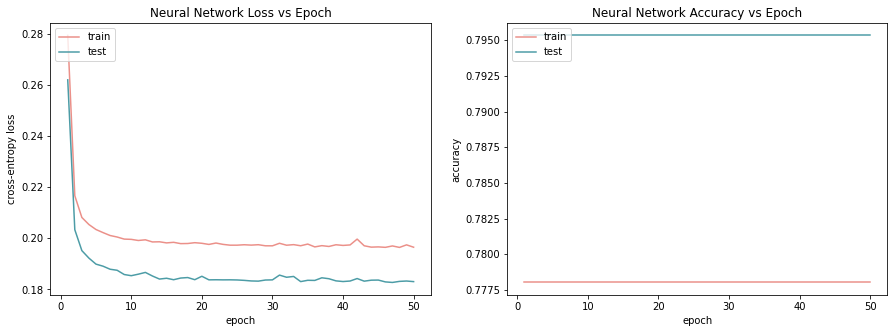

In [ ]:
# Train & Test
net = get_net(num_nodes1, num_nodes2)
net.apply(init_weights)
train_ls, test_ls, acc_train_ls, acc_test_ls = train(net, train_features, train_labels, test_features, test_labels,
                                                     num_epochs, learning_rate, weight_decay, batch_size)

# Neural network performance visualization 
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
ax1.plot(np.arange(1, num_epochs + 1), np.array(train_ls), color="#eb9089")
ax1.plot(np.arange(1, num_epochs + 1), np.array(test_ls), color="#4c9ca6")
ax1.set_title('Neural Network Loss vs Epoch')
ax1.set(xlabel='epoch', ylabel='cross-entropy loss')
ax1.legend(['train', 'test'], loc='upper left')  
ax2.plot(np.arange(1, num_epochs + 1), np.array(acc_train_ls), color="#eb9089")
ax2.plot(np.arange(1, num_epochs + 1), np.array(acc_test_ls), color="#4c9ca6")
ax2.set_title('Neural Network Accuracy vs Epoch')
ax2.set(xlabel='epoch', ylabel='accuracy')
ax2.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Loss & accuracy over epochs overview
for i in range(1, num_epochs):
  print(f'Epoch {i}')
  print(f' train loss {float(train_ls[i]):.4f}, train accuracy {float(acc_train_ls[i]):.4f}')
  print(f' test loss {float(test_ls[i]):.4f}, test accuracy {float(acc_test_ls[i]):.4f}') 
  print("") 

Epoch 1
 train loss 0.2166, train accuracy 0.7780
 test loss 0.2033, test accuracy 0.7953

Epoch 2
 train loss 0.2081, train accuracy 0.7780
 test loss 0.1951, test accuracy 0.7953

Epoch 3
 train loss 0.2054, train accuracy 0.7780
 test loss 0.1922, test accuracy 0.7953

Epoch 4
 train loss 0.2034, train accuracy 0.7780
 test loss 0.1899, test accuracy 0.7953

Epoch 5
 train loss 0.2022, train accuracy 0.7780
 test loss 0.1891, test accuracy 0.7953

Epoch 6
 train loss 0.2011, train accuracy 0.7780
 test loss 0.1879, test accuracy 0.7953

Epoch 7
 train loss 0.2005, train accuracy 0.7780
 test loss 0.1875, test accuracy 0.7953

Epoch 8
 train loss 0.1997, train accuracy 0.7780
 test loss 0.1858, test accuracy 0.7953

Epoch 9
 train loss 0.1996, train accuracy 0.7780
 test loss 0.1853, test accuracy 0.7953

Epoch 10
 train loss 0.1991, train accuracy 0.7780
 test loss 0.1859, test accuracy 0.7953

Epoch 11
 train loss 0.1994, train accuracy 0.7780
 test loss 0.1866, test accuracy 0.795

In [ ]:
# Apply neural network to test set
preds = net(test_features).detach()
_, predicted = torch.max(preds.data,1)

# Reformat 
predictions = pd.Series(predicted.reshape(1, -1)[0])
test_labels = pd.DataFrame(test_labels)

# Confusion matrix test
cm = confusion_matrix(test_labels, predictions)
print("Confusion Matrix")
print(cm)

# Show some results
df_results = pd.concat([products, predictions, test_labels], axis=1)
df_results.columns = ['Sephora Products', 'Predicted Rating', 'True Rating']
df_results.head(10)

Confusion Matrix
[[   0    0    0    1    0]
 [   0    0    0   14    0]
 [   0    0    0  230    0]
 [   0    0    0 1162    0]
 [   0    0    0   54    0]]


,Sephora Products,Predicted Rating,True Rating
0,Thickening Volume Conditioner,3,2
1,Blossom & Bloom™ Ginseng + Biotin Volumizing C...,3,3
2,Sugar Lemon,3,3
3,Rice Dry Oil,3,3
4,Retinol Fusion PM,3,3
5,Brow Tech Matte Pencil,3,3
6,Squalane + Antioxidant Cleansing Oil,3,3
7,Bamboo Body Lotion,3,3
8,Blond Absolu Hydrating Illuminating Shampoo,3,3
9,Encre Interdite 24 Hour Lip Stain,3,2


Ultimately, the trained neural network performs with a *loss* of approximately **0.18** and an *accuracy* of **0.80** on test set. The learning curve seems to flatten out soon, already after a few epochs (less than 10). Also, and strangely, the neural network performs better on test set than train set, which is likely due to the unbalanced classes. In fact, we can observe from the *confusion matrix* how the model classifies all the observations as belonging to class 3 ("4 Stars") - which is the one the net is able to predict best. 

A more balanced train set, with more observations belonging to the other classes (especially class 0 and 1) would presumably have allowed a greater level of accuracy to be achieved.

Furthermore from the plot displaying the *accuracy*, we can observe how the neural network has basically no growth over the epochs: it remains almost stable, both for train and test set.
We can assume that the growth is really minimal at the decimal level, and that the neural network already starts at its best.